<center>
<h4>Universidad Nacional de Córdoba - Facultad de Matemática, Astronomía, Física y Computación</h4>
<h3>Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones</h3>
</center>

<h1> Práctico - Grupo 4 (cohorte 2)</h1>
<h3> Análisis y Visualización de Datos - 2020 </h3>

# Introducción

Durante este práctico vamos a trabajar sobre el dataset [Human Freedom Index 2018](https://www.cato.org/human-freedom-index-new) de el instituto Cato. Este índice mide en detalle lo que entendemos como libertad, utilizando 79 indicadores de libertad personal y económica en distintos aspectos, hasta obtener un hermoso numerito del 1 al 10.

Las variables más importantes sobre las que trabaja el dataset son:

* Rule of Law
* Security and Safety
* Movement
* Religion
* Association, Assembly, and Civil Society
* Expression and Information
* Identity and Relationships
* Size of Government
* Legal System and Property Rights
* Access to Sound Money
* Freedom to Trade Internationally
* Regulation of Credit, Labor, and Business

Nosotros centrarermos nuestro análisis en variables relacionadas a *Identity and Relationships* en paises de Latinoamérica, y los compararemos con las estadísticas globales. La pregunta a responder es simple: **¿Qué niveles de libertad se viven en Latinoamérica, especificamente en cuanto libertades de indentidad?**. Sin embargo, para hacer un análisis de los datos tenemos que platear también estas sub preguntas:

1. ¿Qué significa tener un puntaje de 4.5? Hay que poner los puntajes de la región en contexto con los datos del resto del mundo.
2. ¿Cuál es la tendencia a lo largo de los años? ¿Estamos mejorando, empeorando?
3. En este estudio, la libertad se mide con un estimadores principal: *hf_score* que hace referencia a Human Freedom, que a su vez está calculado en base a dos otros estimadores *ef_score*, para Economic Freedom y *pf_score*, para Personal Freedom. Estos tres estimadores, ¿se relacionan de la misma manera con la libertad de identidad?

Inicialmente, en toda exploración de datos tenemos muy poca información a priori sobre el significado de los datos y tenemos que empezar por comprenderlos. Les proponemos los siguientes ejercicios como guía para comenzar esta exploración.

In [1]:
import matplotlib.pyplot as plt
import numpy
import pandas
import seaborn
import scipy
from scipy import stats
from scipy.stats import spearmanr, pearsonr

In [2]:
seaborn.__version__

'0.10.1'

Si un archivo está disponible en la web, podemos leerlo con pandas utilizando su URL sin necesidad de descargarlo.

In [3]:
dataset = pandas.read_csv(
    'https://object.cato.org/sites/cato.org/files/human-freedom-index-files/human-freedom-index-2019.csv')
dataset.shape

(1620, 120)

In [4]:
dataset.columns  # Way too many columns!

Index(['year', 'ISO_code', 'countries', 'region', 'hf_score', 'hf_rank',
       'hf_quartile', 'pf_rol_procedural', 'pf_rol_civil', 'pf_rol_criminal',
       ...
       'ef_regulation_business_adm', 'ef_regulation_business_bureaucracy',
       'ef_regulation_business_start', 'ef_regulation_business_bribes',
       'ef_regulation_business_licensing', 'ef_regulation_business_compliance',
       'ef_regulation_business', 'ef_regulation', 'ef_score', 'ef_rank'],
      dtype='object', length=120)

Por suerte las columnas tienen un prefijo que nos ayuda a identificar a qué sección pertenecen. Nos quedamos sólo con las que comienzan con *pf_indentity*, junto con otras columnas más generales

In [5]:
score_cols = [col for col in dataset.columns if 'pf_identity' in col] + [
    'pf_score', # Personal Freedom (score)
    'pf_rank', # Personal Freedom (rank)
    'ef_score', # Economic Freedom (score)
    'ef_rank', # Economic Freedom (rank)
    'hf_score', # Human Freedom (score)
    'hf_rank', # Human Freedom (rank)
]

important_cols = ['year', 'ISO_code', 'countries', 'region'] + score_cols

In [6]:
dataset[important_cols]

,year,ISO_code,countries,region,pf_identity_legal,pf_identity_sex_male,pf_identity_sex_female,pf_identity_sex,pf_identity_divorce,pf_identity,pf_score,pf_rank,ef_score,ef_rank,hf_score,hf_rank
0,2017,ALB,Albania,Eastern Europe,0,10,10,10,7.5,5.8,8.01,46,7.67,30,7.84,38
1,2017,DZA,Algeria,Middle East & North Africa,-,0,0,0,0,0,5.2,146,4.77,159,4.99,155
2,2017,AGO,Angola,Sub-Saharan Africa,10,0,0,0,5,5,5.98,121,4.83,158,5.4,151
3,2017,ARG,Argentina,Latin America & the Caribbean,10,10,10,10,10,10,8.04,41,5.67,147,6.86,77
4,2017,ARM,Armenia,Caucasus & Central Asia,7,10,10,10,7.5,8.2,7.15,72,7.7,27,7.42,54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1615,2008,AUS,Australia,Oceania,-,10,10,10,10,10,9.29,7,8.18,6,8.73,4
1616,2008,DNK,Denmark,Western Europe,-,10,10,10,10,10,9.49,3,7.98,9,8.73,4
1617,2008,CHE,Switzerland,Western Europe,-,10,10,10,10,10,9.31,6,8.35,4,8.83,3
1618,2008,NZL,New Zealand,Oceania,-,10,10,10,10,10,9.42,4,8.46,3,8.94,2


Si analizamos los tipos, vemos que casi todas las columnas se leen como objetos debido a que los valores nulos están marcados con `-`. Los vamos a eliminar y volveremos a convertir las columnas con puntajes a tipo numérico.

In [7]:
dataset.dtypes

year                                  int64
ISO_code                             object
countries                            object
region                               object
hf_score                             object
                                      ...  
ef_regulation_business_compliance    object
ef_regulation_business               object
ef_regulation                        object
ef_score                             object
ef_rank                              object
Length: 120, dtype: object

In [8]:
dataset = dataset[important_cols].replace('-', numpy.nan)
for score_col in score_cols:
  dataset[score_col] = pandas.to_numeric(dataset[score_col])
dataset

,year,ISO_code,countries,region,pf_identity_legal,pf_identity_sex_male,pf_identity_sex_female,pf_identity_sex,pf_identity_divorce,pf_identity,pf_score,pf_rank,ef_score,ef_rank,hf_score,hf_rank
0,2017,ALB,Albania,Eastern Europe,0.0,10.0,10.0,10.0,7.5,5.8,8.01,46.0,7.67,30.0,7.84,38.0
1,2017,DZA,Algeria,Middle East & North Africa,NaN,0.0,0.0,0.0,0.0,0.0,5.20,146.0,4.77,159.0,4.99,155.0
2,2017,AGO,Angola,Sub-Saharan Africa,10.0,0.0,0.0,0.0,5.0,5.0,5.98,121.0,4.83,158.0,5.40,151.0
3,2017,ARG,Argentina,Latin America & the Caribbean,10.0,10.0,10.0,10.0,10.0,10.0,8.04,41.0,5.67,147.0,6.86,77.0
4,2017,ARM,Armenia,Caucasus & Central Asia,7.0,10.0,10.0,10.0,7.5,8.2,7.15,72.0,7.70,27.0,7.42,54.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1615,2008,AUS,Australia,Oceania,NaN,10.0,10.0,10.0,10.0,10.0,9.29,7.0,8.18,6.0,8.73,4.0
1616,2008,DNK,Denmark,Western Europe,NaN,10.0,10.0,10.0,10.0,10.0,9.49,3.0,7.98,9.0,8.73,4.0
1617,2008,CHE,Switzerland,Western Europe,NaN,10.0,10.0,10.0,10.0,10.0,9.31,6.0,8.35,4.0,8.83,3.0
1618,2008,NZL,New Zealand,Oceania,NaN,10.0,10.0,10.0,10.0,10.0,9.42,4.0,8.46,3.0,8.94,2.0


# Parte 1

Luego de las clases del primer fin de semana, ya tenemos las herramientas para responder las siguientes preguntas:

## 1. Estadísticos descriptivos  

#### 1. Para comenzar con un pantallazo de los datos, calcular el rango de las variables.

A continuación, se detalla el rango de las variables del dataset:

In [9]:
dataset.iloc[:,4:16].describe().iloc[[3, 7],:]

,pf_identity_legal,pf_identity_sex_male,pf_identity_sex_female,pf_identity_sex,pf_identity_divorce,pf_identity,pf_score,pf_rank,ef_score,ef_rank,hf_score,hf_rank
min,0.0,0.0,0.0,0.0,0.0,0.0,2.22,1.0,2.58,1.0,3.69,1.0
max,10.0,10.0,10.0,10.0,10.0,10.0,9.56,162.0,9.11,162.0,9.12,162.0


#### 2. Para cada país, tenemos varias realizaciones para cada variable pf_identity y hf_score. Si queremos comparar un país con otro, ¿cuál es la manera adecuada de hacerlo? Por ejemplo, ¿nos quedamos con un único valor? ¿o comparamos todos los valores? ¿usamos el promedio? ¿usamos la mediana?

Si queremos comparar los indicadores entre países, los pasos a seguir dependerán del tipo de comparación que deseemos realizar y de la disponibilidad de valores para ambas variables en los países a comparar. Por ejemplo, si quisiéramos analizar la evolución de dichas variables entre los países a lo largo del tiempo podríamos comparar todos los valores año a año, o evaluar la tendencia a lo largo del tiempo que dicha variable tuvo en cada país. Si quisiéramos evaluar si el valor de una variable es mayor en un país que en el otro, entonces deberíamos tener en cuenta el promedio de valores y cada año como una repetición de dicha variable, para así poder tener un promedio y desvío estándar para comparar, por ejemplo, a través de un test de comparación de medias. Si particularmente dichas variables mostraran distribuciones con un marcado sesgo entre los años analizados, quizás entonces la mediana sería una mejor medida de resumen, ya que el promedio se vería fuertemente afectado por los valores extremos.

En este caso, como nos interesa evaluar los valores de los índices para cada país o región den general (sin darle importancia a algun año en particular), tomamos todos los años provistos por el dataset.

#### 3. Obtener media, mediana y desviación estándar de las variables pf_identity y hf_score en el mundo y compararla con la de Latinoamérica y el caribe. Usar la respuesta del punto anterior para justificar si la comparación es válida o no.

In [10]:
# Creamos una tabla con los valores de media, desvío estándar y mediana a nivel global y para Latinoamérica y el Caribe (LatyCar)

dataset_lat = dataset[dataset.region == 'Latin America & the Caribbean']

data_frame = {"pf_identity Global" : [dataset.pf_identity.mean(), dataset.pf_identity.std(), dataset.pf_identity.median()], 
              "pf_identity LatyCar" : [dataset_lat.pf_identity.mean(), dataset_lat.pf_identity.std(), dataset_lat.pf_identity.median()], 
              "hf_score Global" : [dataset.hf_score.mean(), dataset.hf_score.std(), dataset.hf_score.median()], 
              "hf_score LatyCar" : [dataset_lat.hf_score.mean(), dataset_lat.hf_score.std(), dataset_lat.hf_score.median()]
             }
pandas.DataFrame(data_frame, index = ["Media", "Dev Std", "Mediana"])

,pf_identity Global,pf_identity LatyCar,hf_score Global,hf_score LatyCar
Media,7.280649,8.582171,6.978214,7.036977
Dev Std,3.181577,1.875832,1.056239,0.634897
Mediana,8.800000,10.000000,6.900000,7.020000


Se observa que para Libertad de identidad y relaciones la desviación estándar es alta (prácticamente la mitad de la media a nivel global, y un valor de casi 2 para Latinoamérica y el Caribe). Esto nos indica que no conviene utilizar la media para Libertad de identidad y relaciones para comparar entre el mundo y otra región, ya que los valores se encuentran muy dispersos entre sí (ya que esta medida de posición es muy afectada por valores extremos).

En el caso de Libertad humana, el desvío estándar es menor, y la media es muy similar a la mediana tanto a nivel global como para Latinoamérica y el Caribe. Esto nos indica que las comparaciones de valores medios entre estas dos regiones son más adecuados para esta variable que para Libertad de identidad y relaciones. Tambien da un primer indicio de la distribución de los datos, que podría llegar a parecerse a una distribución normal (en donde la media y la mediana coinciden).

#### 4. ¿Tiene sentido calcular la moda?

Siendo que las variables analizadas son de naturaleza continua, el cálculo de la moda carece de sentido, ya que esta se calcula para variables discretas (se define como el valor más repetido). El cálculo de esta medida tendría sentido si discretizaramos estas variables continuas en intervalos iguales, y analizamos cuál es el intervalo más repetido.

#### 5. ¿Cómo pueden sanearse los valores faltantes?

Los datos faltantes pueden sanearse de diferentes maneras. Si el dato faltante es el valor del índice en un año particular para un país determinado, una forma de hacerlo sería calcular la media de los valores de ese índice entre el año anterior y el año siguiente. Otra forma sería calcular la media de la región para ese índice ese año, y asignarlo al valor faltante. Esta última estrategia sería válida también para cuando los datos faltantes de un país se encuentran a lo largo de varios años seguidos. Sin embargo, si se da el caso de que un determinado país no tiene dato para un índice en todos los años, quizás una mejor estrategia sea eliminar a dicho país (para ese índice) para futuros análisis. Todo depende de la pregunta que se desea responder. Por ejemplo, para este último caso, esta última estrategia podría aplicarse si se desea comparar los valores medios de un índice entre regiones.

#### 6. ¿Encuentra outliers en estas dos variables? ¿Qué método utiliza para detectarlos? Los outliers, ¿son globales o por grupo? ¿Los eliminaría del conjunto de datos?

Los outliers se definen como valores que se alejan del patrón de distribución de los datos. Existen diversas maneras de detectar outliers. Uno de los más utilizadas es definir a un dato como outlier cuando el valor de este se encuentra 1,5 * IQR (rango intercuartílico) veces por encima del tercer cuartil o 1,5 * IQR veces por debajo del primer cuartil. La función boxplot de seaborn permite plotear un gráfico de caja en donde los puntos que se encuentran por encima o por debajo de los límites de la  caja se definen como outliers. El criterio para definirlos como tales puede especificarse en el argumento “whis”, y por defecto está seteado en 1,5.

A continuación graficamos los boxplots por región para las dos variables.


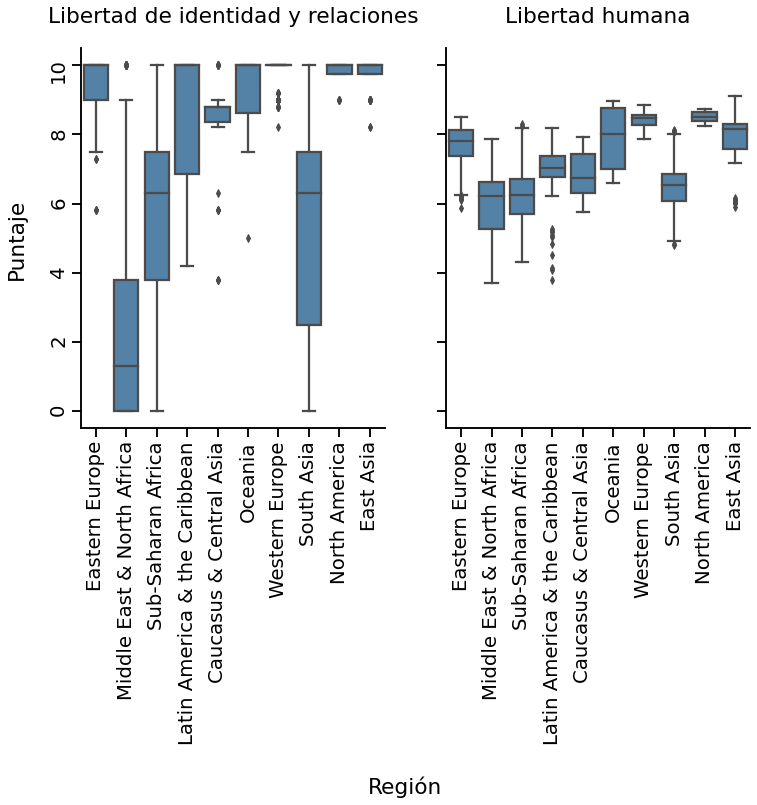

In [47]:
fig, ax = plt.subplots(1,2,  figsize=(12,7), sharex=True, sharey=True)

# Boxplot pf_identity por region
seaborn.boxplot(data=dataset,
               x='region', y='pf_identity', color = "steelblue", ax=ax[0])
ax[0].set(xlabel=None, ylabel=None)
ax[0].set_title('Libertad de identidad y relaciones')
ax[0].title.set_position([.5, 1.05])
ax[0].tick_params(labelrotation=90)

# Boxplot hf_score por region
seaborn.boxplot(data=dataset,
               x='region', y='hf_score', color = "steelblue", ax=ax[1])
ax[1].set(xlabel=None, ylabel=None)
ax[1].set_title('Libertad humana')
ax[1].title.set_position([.5, 1.05])
ax[1].tick_params(labelrotation=90)
fig.text(0.5, -0.6, 'Región', ha='center')
fig.text(0.04, 0.5, 'Puntaje', va='center', rotation='vertical')
for a in ax.flat:
    a.label_outer()
seaborn.despine()

Al analizar los gráficos de caja para la variable Libertad de identidad y relaciones, se observan outliers en la mayoría de las regiones.
En el caso de los gráficos de caja para la variable Libertad humana, al separar por región, se observa la presencia de outliers principalmente en Latinoamérica y el Caribe; mientras que en el resto de las regiones prácticamente no se observan. 

A continuación, calculamos los valores mínimos y máximos más allá de los cuales los datos se definen como outliers para el índice de Libertad humana. Analizamos para el caso de Latinoamérica y El Caribe, para detectar si esos outliers se corresponden, por ejemplo, con un país en particular o con una serie de años particulares.

In [12]:
cuartil_1 = numpy.nanpercentile(dataset_lat.hf_score, 25)
cuartil_3 = numpy.nanpercentile(dataset_lat.hf_score, 75)
rango_intercuartilico = cuartil_3 - cuartil_1
minimo = cuartil_1 - (rango_intercuartilico * 1.5)
maximo = cuartil_3 + (rango_intercuartilico * 1.5)
print("Detección de outliers de Libertad humana\nValor mínimo: " + str(minimo) + "\nValor máximo: " + str(maximo))
dataset_lat[(dataset_lat["hf_score"] < minimo) | (dataset_lat["hf_score"] > maximo)][["year", "countries", "hf_score"]]

Detección de outliers de Libertad humana
Valor mínimo: 5.84
Valor máximo: 8.3


,year,countries,hf_score
157,2017,Venezuela,3.80
319,2016,Venezuela,4.13
481,2015,Venezuela,4.08
643,2014,Venezuela,4.50
805,2013,Venezuela,4.84
967,2012,Venezuela,5.09
1129,2011,Venezuela,5.21
1291,2010,Venezuela,5.02
1453,2009,Venezuela,5.18
1484,2008,Venezuela,5.27


Se observa que los outliers observados para la región Latinoamérica y el Caribe se corresponden únicamente con Venezuela. En el futuro, si lo que se desea es comparar este indicador entre regiones (por ejemplo, Latinoamérica y el Caribe vs Oceanía), una opción válida sería descartar los datos referidos a Venezuela, ya que estos se desvían de la distribución de los datos típica de la región.

A continuación, hacemos el mismo análisis para otras regiones del mundo (Europa del Este y Asia del Este):

In [13]:
dataset_EEurope = dataset[dataset.region == "Eastern Europe"]

cuartil_1 = numpy.nanpercentile(dataset_EEurope.hf_score, 25)
cuartil_3 = numpy.nanpercentile(dataset_EEurope.hf_score, 75)
rango_intercuartilico = cuartil_3 - cuartil_1
minimo = cuartil_1 - (rango_intercuartilico * 1.5)
maximo = cuartil_3 + (rango_intercuartilico * 1.5)
print("Detección de outliers de Libertad humana: Europa del Este \nValor mínimo: " + str(minimo) + "\nValor máximo: " + str(maximo))
dataset_EEurope[(dataset_EEurope["hf_score"] < minimo) | (dataset_EEurope["hf_score"] > maximo)][["year", "countries", "hf_score"]]

Detección de outliers de Libertad humana: Europa del Este 
Valor mínimo: 6.243750000000002
Valor máximo: 9.233749999999997


,year,countries,hf_score
174,2016,Belarus,6.16
286,2016,Russia,6.24
314,2016,Ukraine,6.16
448,2015,Russia,6.09
476,2015,Ukraine,5.88
610,2014,Russia,6.23
638,2014,Ukraine,6.14


In [14]:
dataset_EAsia = dataset[dataset.region == "East Asia"]

cuartil_1 = numpy.nanpercentile(dataset_EEurope.hf_score, 25)
cuartil_3 = numpy.nanpercentile(dataset_EEurope.hf_score, 75)
rango_intercuartilico = cuartil_3 - cuartil_1
minimo = cuartil_1 - (rango_intercuartilico * 1.5)
maximo = cuartil_3 + (rango_intercuartilico * 1.5)
print("Detección de outliers de Libertad humana: Asia del Este \nValor mínimo: " + str(minimo) + "\nValor máximo: " + str(maximo))
dataset_EAsia[(dataset_EAsia["hf_score"] < minimo) | (dataset_EAsia["hf_score"] > maximo)][["year", "countries", "hf_score"]]

Detección de outliers de Libertad humana: Asia del Este 
Valor mínimo: 6.243750000000002
Valor máximo: 9.233749999999997


,year,countries,hf_score
32,2017,China,6.17
194,2016,China,6.02
356,2015,China,5.91
518,2014,China,6.02
680,2013,China,6.10
842,2012,China,6.07
1004,2011,China,6.05
1166,2010,China,6.03
1328,2009,China,6.06
1506,2008,China,6.11


Se observan también que los outliers de la región "Este de Europa" se corresponden en su mayoría a dos países: Rusia y Ucrania. Mientras que para los outliers de "Este de Asia", estos se corresponden con todos los años para China. Corresponderá en cada caso y dependiendo la pregunta de análisis, eliminar estos outliers o mantenerlos en el dataset.

## 2. Agregación de datos

#### 1. Grafiquen la media de la variable pf_identity y hf_score a través de los años.

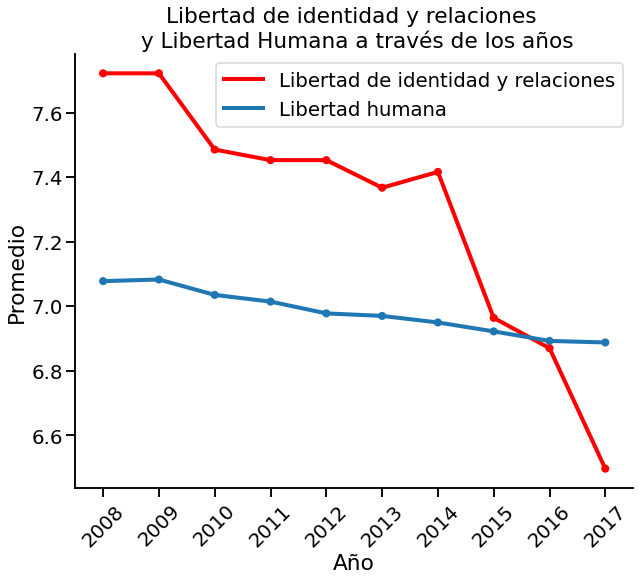

In [15]:
seaborn.set_context(context='talk', font_scale=1.2)

# Media global por año
df_mean_peryear = dataset.groupby("year", as_index = False).mean()

# Libertad personal (identidad y relaciones) a través de los años
plt.figure(figsize=(10,8))
seaborn.pointplot(data=df_mean_peryear, label = "Libertad personal",
                  x='year', y='pf_identity',
                  dodge=True, ci=None, color = "red",
                  markers='.', linestyles='-', errwidth=1, capsize=0.2)

seaborn.pointplot(data=df_mean_peryear, label = "Libertad humana",
                  x='year', y='hf_score',
                  dodge=True, ci=None,
                  markers='.', linestyles='-', errwidth=1, capsize=0.2)

plt.legend(labels=['Libertad de identidad y relaciones', 'Libertad humana'])

plt.ylabel('Promedio')
plt.xlabel('Año')
plt.title('Libertad de identidad y relaciones \n y Libertad Humana a través de los años')
plt.xticks(rotation=45)
seaborn.despine()


Al graficar los valores medios para la libertad de identidad y relaciones a nivel global, se observa una tendencia a la baja de alrededor de un punto (de 7.6 a 6.6 aproximadamente). En cambio, al graficar los valores medios para la libertad humana a nivel global, si bien gráficamente se observa una tendencia a la baja, esta es muy leve.

#### 2. Realicen los mismos gráficos, pero separando por regiones (Cada variable en un gráfico distinto, sino no se ve nada). ¿La tendencia observada, es la misma que si no dividimos por regiones?

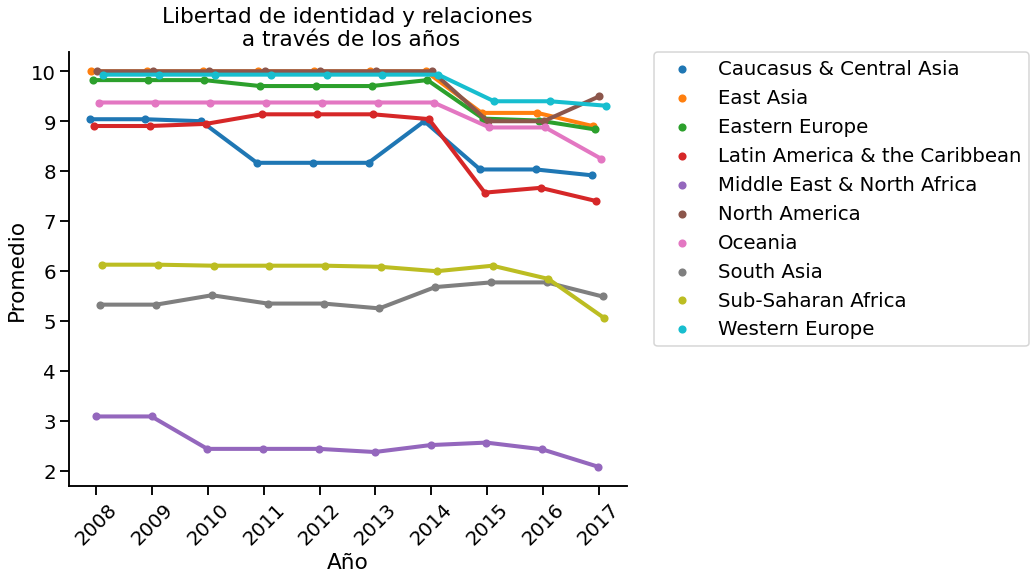

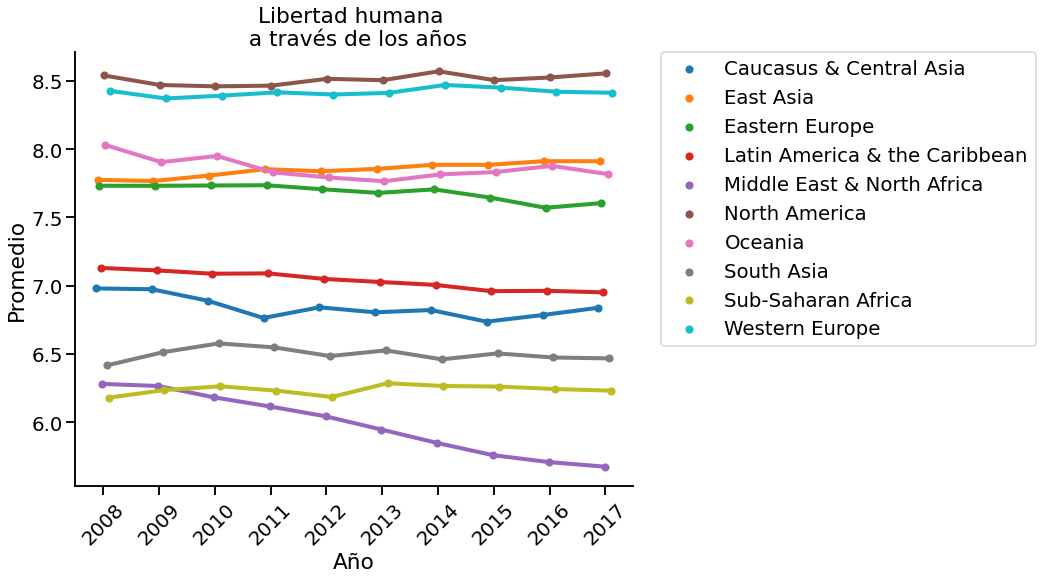

In [48]:
df_mean_peryear_region = dataset.groupby(["year", "region"], as_index = False).mean()

# Libertad personal (identidad y relaciones) a través de los años, por región

plt.figure(figsize=(10,8))
seaborn.pointplot(data=df_mean_peryear_region,
                  x='year', y='pf_identity',
                  hue = "region" , dodge=True, ci=None,
                  markers='.', linestyles='-', capsize=0.2)

plt.ylabel('Promedio')
plt.xlabel('Año')
plt.title('Libertad de identidad y relaciones\n a través de los años')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
seaborn.despine()

# Libertad humana a través de los años, por región

plt.figure(figsize=(10,8))
seaborn.pointplot(data=df_mean_peryear_region,
                  x='year', y='hf_score',
                  hue = "region" , dodge=True, ci=None,
                  markers='.', linestyles='-', errwidth=1, capsize=0.2)

plt.ylabel('Promedio')
plt.xlabel('Año')
plt.title('Libertad humana \n a través de los años')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
seaborn.despine()

Al graficar los valores medios para la libertad de identidad y relaciones por región, se observa variabilidad entre estas en función del tiempo. Es decir, para algunas regiones (como Latinoamérica y El Caribe, y Oceanía) se observa una tendencia a la baja abrupta a partir del 2014, mientras que para otras regiones (como el sur de Asia y África) se mantiene relativamente constante. Además se identifica, visualmente, la presencia de 3 grupos de regiones con diferencias marcadas a lo largo de todo el período analizado. La región de Oriente Medio y Norte de África presenta los valores mas bajos, alejado del grupo conformado por África Subsahariana y el Sur de Asia, que muestran valores medios. El grupo restante contiene al resto de las regiones no mencionadas, y muestran los valores más altos.

Respecto a los valores medios observados para la libertad humana por región, se observa que para la mayoría de las regiones los valores se mantienen constantes (con excepción del Este y Norte de África, la cual tiende a bajar a medida que pasan los años). Esto es consistente con el análisis de los valores medios a nivel global, el cual arrojó que hay poca variación del índice a través de los años.

#### 3. Si lo consideran necesario, grafiquen algunos países de Latinoamerica para tratar de explicar la tendencia de la variable pf_identity en la región. ¿Cómo seleccionaron los países relevantes a esa tendencia?

Para saber si hay algunos países de Latinoamética y el Caribe que influyen más que otros en la tendencia a la baja para el índice pf_identity, podemos calcular la ddiferencia entre el valor ovservado en 2017 menos el valor observado en 2017 (Delta).

In [49]:
paises = dataset[dataset.region == "Latin America & the Caribbean"].countries.unique()

dic_deltas = {}
for pais in paises:
    valor_2008 = dataset[(dataset.countries == pais) & (dataset.year == 2008)].pf_identity.values[0]
    valor_2017 = dataset[(dataset.countries == pais) & (dataset.year == 2017)].pf_identity.values[0]
    dic_deltas[pais] = valor_2017 - valor_2008

df_deltas = pandas.DataFrame(dic_deltas.items(), columns = ["Pais", "Delta"])
df_deltas.sort_values("Delta")[:3]

,Pais,Delta
25,Venezuela,-5.8
20,Paraguay,-5.0
9,Dominican Rep.,-4.2


A partir de la tabla podemos elegir, a modo de ejemplo, los tres países con menor Delta: Venezuela, Paraguay y República Dominicana.

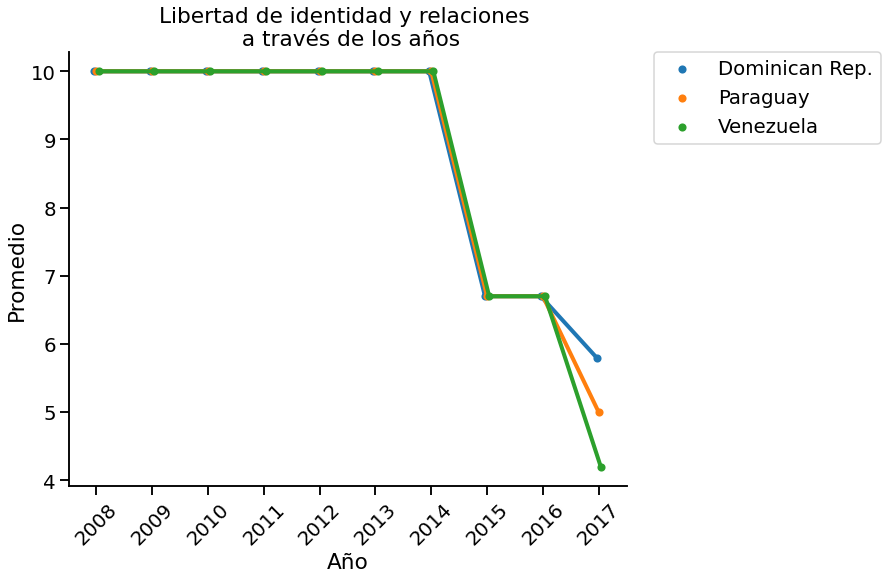

In [18]:
# Subset dataset por Venezuela, Nicaragua y República Dominicana

#datasetLAT = dataset[dataset["region"] == "Latin America & the Caribbean"]
datasetLAT = dataset[dataset["countries"].isin(['Venezuela', 'Paraguay', 'Dominican Rep.'])]

# Libertad personal (identidad y relaciones) a través de los años: Argentina y países limítrofes
df_mean_peryear_LAT = datasetLAT.groupby(["year", "countries"], as_index = False).mean()

plt.figure(figsize=(10,8))
seaborn.pointplot(data=df_mean_peryear_LAT,
                  x='year', y='pf_identity',
                  hue = "countries" , dodge=True, ci=None,
                  markers='.', linestyles='-', errwidth=1, capsize=0.2)

plt.ylabel('Puntaje')
plt.xlabel('Año')
plt.title('Libertad de identidad y relaciones \n a través de los años')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
seaborn.despine()

Se observa, como se esperaba, que los puntajes de Libertad de identidad y relaciones caen abruptamente a partir del año 2014.

#### Consigna extra: Sólo por curiosidad, graficar la tendencia de hf_score y ef_score a través de los años. ¿Tienen alguna hipótesis para este comportamiento?

Dado que el índice de Libertad humana se calcula como el promedio entre Libertad personal y Libertad económica, es conveniente graficar los tres índices en el mismo gráfico, y observar la tendencia a través de los años:

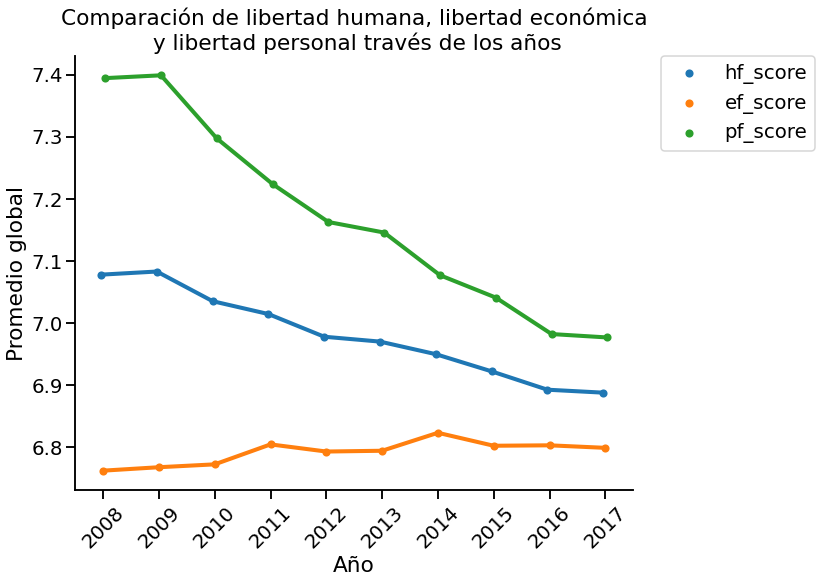

In [20]:
dataset_large2 = pandas.melt(dataset, id_vars = "year", value_vars = ("hf_score", "ef_score", "pf_score"))
plt.figure(figsize=(10,8))
seaborn.pointplot(data=dataset_large2,
                  x='year', y='value',
                  hue = "variable" , dodge=True, ci=None,
                  markers='.', linestyles='-', errwidth=1, capsize=0.2)

plt.ylabel('Promedio global')
plt.xlabel('Año')
plt.title('Comparación de libertad humana, libertad económica\n y libertad personal través de los años')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
seaborn.despine()

A partir del gráfico, puede observarse una tendencia de descenso para el indicador de Libertad humana, mientras que el indicador para Libertad económica tiende a aumentar en el mismo lapso de años. Se observa en cambio un descenso abrupto del índice de Libertad humana. Dado que el índice de Libertad humana es el promedio entre los otros dos índices, su curva se ubica entre las curvas de los índices que componen su cálculo. En conclusión, el descenso abrupto del índice de libertad personal influye más que el leve aumento del índice de libertad económica sobre el valor del índice de libertad humana.

## 3. Distribuciones

#### 1. Graficar en un mismo histograma la distribución de la variable *pf_identity* en global, y en Latinoamérica y el caribe. Repetir para la variable *hf_score*. ¿Visualmente, a qué tipo de distribución corresponde cada variable? ¿Es correcto utilizar todos el conjunto de valores disponibles para esa region en estos gráficos?


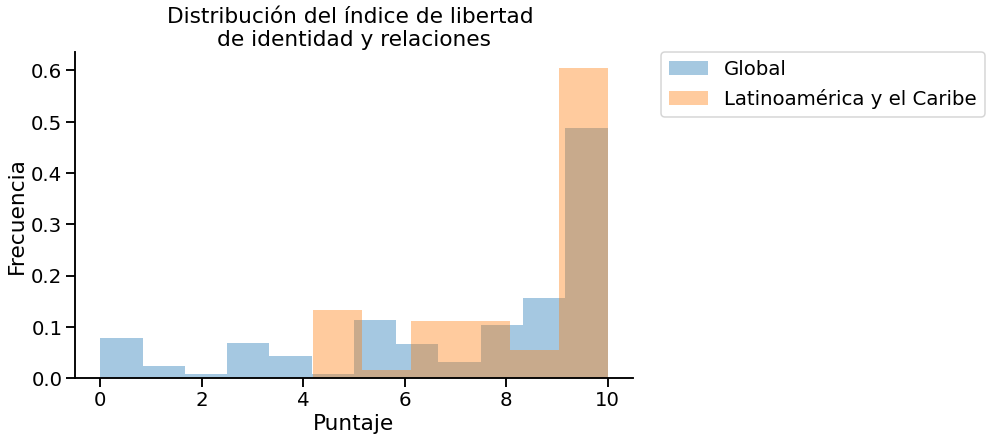

In [24]:
plt.figure(figsize=(10,6))
plt.title('Distribución del índice de libertad \nde identidad y relaciones')
seaborn.distplot(dataset.pf_identity, label='Global', kde=False, norm_hist = True)
seaborn.distplot(dataset_lat.pf_identity, label='Latinoamérica y el Caribe', kde=False, norm_hist = True)
plt.ylabel('Frecuencia')
plt.xlabel('Puntaje')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
seaborn.despine()


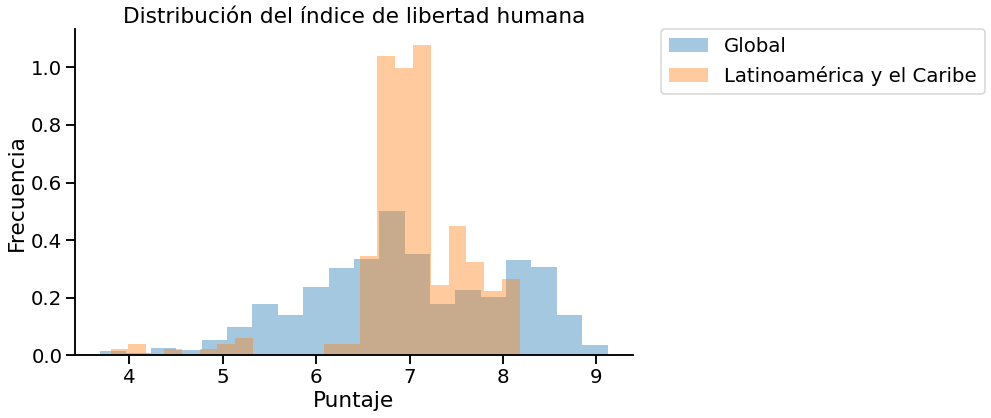

In [25]:
plt.figure(figsize=(10,6))
plt.title('Distribución del índice de libertad humana')
seaborn.distplot(dataset.hf_score, label='Global', kde=False, norm_hist = True)
seaborn.distplot(dataset_lat.hf_score, label='Latinoamérica y el Caribe', kde=False, norm_hist = True)
plt.ylabel('Frecuencia')
plt.xlabel('Puntaje')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
seaborn.despine()

Para el índice de libertad de identidad y relaciones, las distribuciones tanto a a nivel global como en Latinoamérica y el Caribe, visualmente, no se asemejan a una distribución conocida.

Para el índice de libertad humana, visualmente los valores de libertad a nivel global y en Latinoamérica y el Caribe, tienden a parecerse a una distribución normal.

## 4. Correlaciones y Relaciones

En este ejercicio queremos responder a las preguntas

* Las libertades personales y económicas, ¿van siempre de la mano?
* ¿Cómo se relacionan ambas con las libertades respectivas a las relaciones personales?

Para ello, analizaremos las correlaciones entre las variables pf_identity, pf_score y ef_score. 

Como pf_indentity contribuye al cálculo de pf_score esperamos hallar algún grado de correlación. Lo contrario podría ocurrir con ef_score. 

#### 1. ¿Qué conclusiones puede sacar de un gráfico pairplot de estas tres variables? ¿Es adecuado para los valores de pf_identity? ¿Por qué?

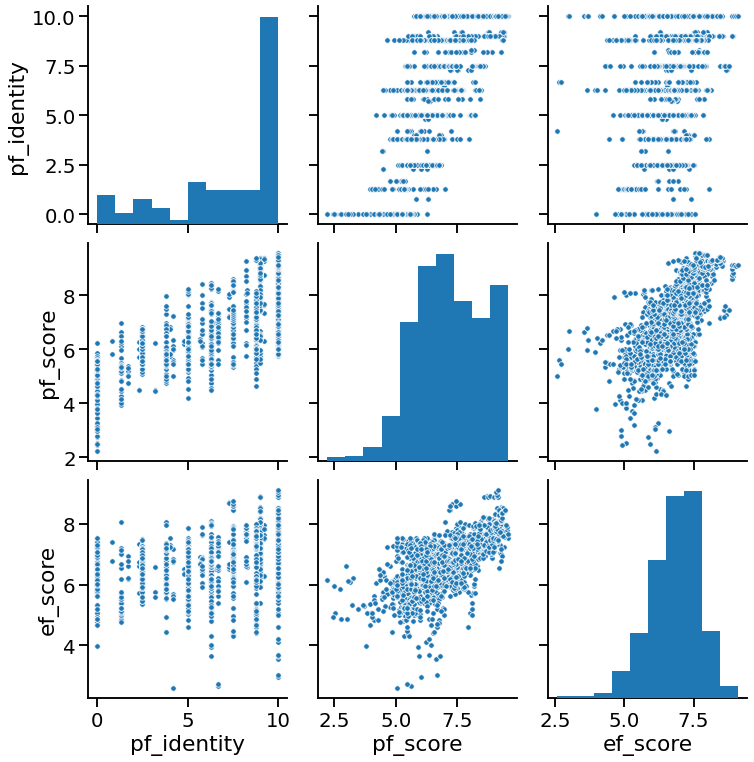

In [50]:
my_data = dataset[['pf_identity', 'pf_score', 'ef_score']]

seaborn.pairplot(my_data, plot_kws={"s": 30}, height = 3.5)

Del grafico se observa que existe una correlacion visual entre libertad personal (pf_score) y libertad economica (ef_score). 
Al ser la variable libertad de identidad y relaciones (pf_identity) una variable discreta, no es adecuada su representacion con un grafico pairplot, ya que para un mismo valor de índice, los puntos se grafican uno encima del otro (en columna).

#### 2. Graficar la correlación (visual) entre pf_identity y pf_score; y entre pf_identity y ef_score. Analizar el resultado, ¿se pueden sacar conclusiones? Tengan en cuenta que como pf_identity es el resultado de un promedio, sólo toma algunos valores. Es, en la práctica, discreta, y eso afecta al tipo de gráfico que podemos usar.

Siendo la variable Libertad de identidad y relaciones (pf_identity) discreta, la función regplot es más adecuada que un pairplot. Esta función grafica los valores medios para cada valor del índice con un punto, y un intervalo de confianza asociado (95%).

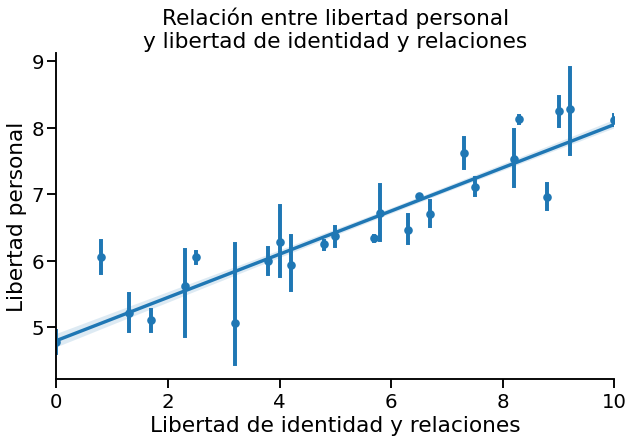

In [179]:
plt.figure(figsize=(10,6))
seaborn.regplot(data=dataset, x='pf_identity',
                y='pf_score', x_estimator=numpy.mean)
plt.title('Relación entre libertad personal\ny libertad de identidad y relaciones')
plt.xlabel("Libertad de identidad y relaciones")
plt.ylabel("Libertad personal")
seaborn.despine()

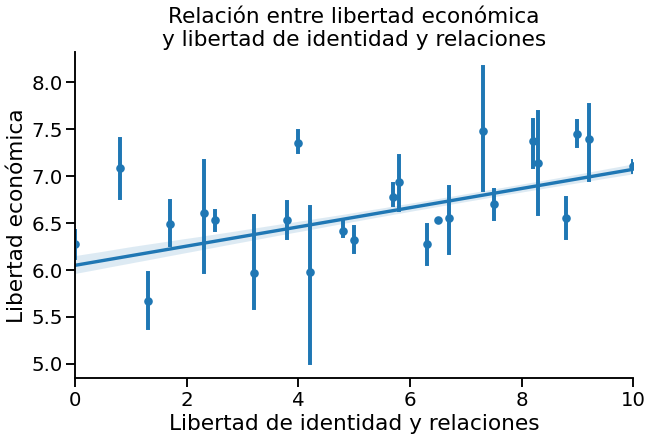

In [178]:
plt.figure(figsize=(10,6))
seaborn.regplot(data=dataset, x='pf_identity',
                y='ef_score', x_estimator=numpy.mean)
plt.title('Relación entre libertad económica\ny libertad de identidad y relaciones')
plt.xlabel("Libertad de identidad y relaciones")
plt.ylabel("Libertad económica")
seaborn.despine()

Existe una correlacion visual entre libertad de identidad y relaciones (pf_identity) y libertad personal (pf_score) lo cual tiene sentido ya que pf_identity es un componente del pf_score.
Por otro lado existe una baja correlacion entre libertad de identidad y relaciones (pf_identity) y libertad economica (ef_score).

#### 3. Convertir estas variables en categóricas, es decir, a partir de pf_indentity generar otra variable pf_identity_segment que tome los valores high, medium y low. Pueden hacerlo con una función escrita por ustedes, o usando alguna función de pandas como pandas.cut o pandas.dcut. Repetir para ef_score y pf_score. El criterio para decidir qué intervalos de valores corresponden a cada categoría tienen que decidirlo ustedes, pueden usar los estadísticos mediana y los cuartiles.

In [51]:
# Debido a que la distribución de pf_identity no es continua elegimos los siguientes intervalos
# Mediana como punto medio, valores por debajo del Q1 = LOW, entre Q1 y Q3 = MEDIUM y por encima de Q3 = HIGH

def segment(column, etiq=None):
 lim_cut = [None] * 4
 count = 0
 for i in range(3, 8):
   if i == 5:   # para no contar con el máximo sino que con el 75%
     continue
   lim_cut[count] = column.describe()[i]
   count += 1
 if lim_cut[2] == lim_cut[3]:
   lim_cut[2] -= 0.1
 lim_cut[3] += 0.1
 lim_cut[0] -=0.1
 return pandas.cut(column, lim_cut, labels=etiq)

In [53]:
# Genero nuevas columnas con los segmentos calculados
dataset['pf_identity_segment'] =  segment(dataset.pf_identity, etiq=[0, 1, 2])
dataset['pf_score_segment'] =  segment(dataset.pf_score, etiq=[0, 1, 2])
dataset['ef_score_segment'] =  segment(dataset.ef_score, etiq=[0, 1, 2])

#### 4. Graficar la correlación (visual) entre estas tres variables categoricas usando gráficos de calor (heatmaps). Note: van a necesitar 3 gráficos distintos, porque en cada uno podemos incluir sólo 2 variables.

(array([0.5, 1.5, 2.5]), <a list of 3 Text major ticklabel objects>)

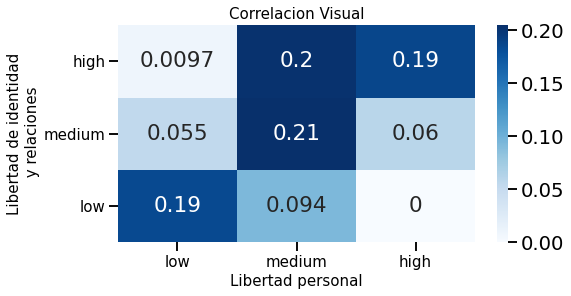

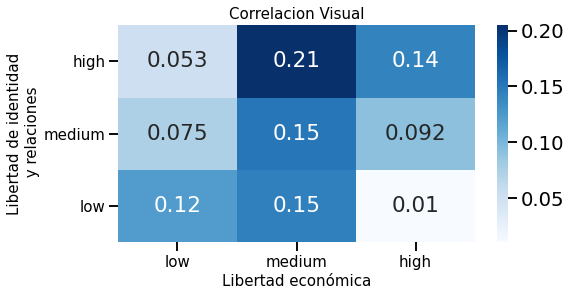

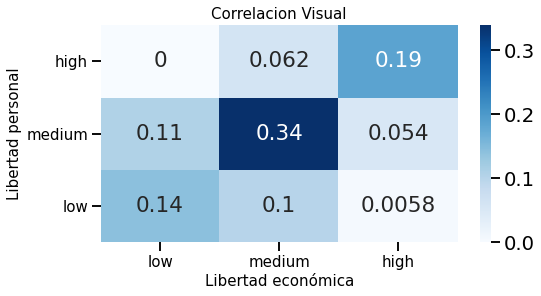

In [217]:
plt.figure(figsize=(8,4))
plt.title("Correlacion Visual", fontsize = 15)
exp = pandas.crosstab(dataset.pf_identity_segment, dataset.pf_score_segment, normalize=True)
ax = seaborn.heatmap(exp, annot=True, cmap= 'Blues', xticklabels= ['low', 'medium', 'high'], 
                     yticklabels= ['low', 'medium', 'high'])
ax.invert_yaxis()
plt.xlabel("Libertad personal", fontsize = 15)
plt.ylabel("Libertad de identidad\n y relaciones", fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)

plt.figure(figsize=(8,4))
plt.title("Correlacion Visual", fontsize = 15)
exp = pandas.crosstab(dataset.pf_identity_segment, dataset.ef_score_segment, normalize=True)
ax = seaborn.heatmap(exp, annot=True, cmap= 'Blues', xticklabels= ['low', 'medium', 'high'], yticklabels= ['low', 'medium', 'high'])
ax.invert_yaxis()
plt.xlabel("Libertad económica", fontsize = 15)
plt.ylabel("Libertad de identidad\n y relaciones", fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)

plt.figure(figsize=(8,4))
plt.title("Correlacion Visual", fontsize = 15)
exp = pandas.crosstab(dataset.pf_score_segment, dataset.ef_score_segment, normalize=True)
ax = seaborn.heatmap(exp, annot=True, cmap= 'Blues', xticklabels= ['low', 'medium', 'high'], yticklabels= ['low', 'medium', 'high'])
ax.invert_yaxis()
plt.xlabel("Libertad económica", fontsize = 15)
plt.ylabel("Libertad personal", fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)

Los heatmaps permiten analizar la correlación visual entre variables discreta, el cual arroja una matríz con celdas coloreadas y una escala que indica la frecuencia de observación de la categoría de una variable con la categoría de la otra variable. En un gráfico de correlación perfecta, las celdas de alguna de las diagonales debieran contener valores tales que su suma sea igual a 1, y valores nulos (ceros) en el resto de las celdas. Con este criterio, en este caso, puede observarse una mayor correlación visual entre Libertad personal y Libertad de Identidad y Relaciones, que entre el resto de las variables analizadas.

# Parte 2

Luego del segundo fin de semana de clase, podemos revisitar nuestro trabajo anterior y completarlo respondiendo a las siguientes preguntas:

#### Distribuciones

1. Realizar una prueba de Kolmogorov-Smirnof para comprobar analíticamente si estas variables responden la distribución propuesta en el ejercicio anterior. Hint: podés usar https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.kstest.html, pero hay que tener en cuenta que si la distribución es "norm", entonces va a comparar los datos con una distribución normal con media 0 y desviación estándar 1. Se puede utilizar la distribución sobre todos los datos o sólo sobre Latinoamérica.

Visualmente, las distribuciones para pf_identity (tanto analizadas globalmente como para Latinoamérica y el Caribe) no se asemejaban a ninguna distribución conocida. Para hf_score (Libertad humana) las ditribuciones se asemejaban un poco a una distribución normal. A continuación pondremos a prueba la distribución para hf_score a nivel global, a modo de ejemplo. Para ello realizaremos una prueba de Kolmogorov-Smirnof mediante la función kstest de scipy. Para hacerlo correctamente, especificamos que comparamos los datos de la distribución que queremos poner a prueba (hf_score a nivel global) con una distribución normal, y especificamos la media y al desvío estándar.

In [45]:
hfscore_global = numpy.array(dataset.hf_score.dropna())
scipy.stats.kstest(hfscore_g, 'norm', args=(hfscore_g.mean(), hfscore_g.std()))

KstestResult(statistic=0.06497724505720437, pvalue=4.267579068369586e-06)

Se observa un p-valor muy pequeño y menor al nivel de significancia de referencia (0.05). Dado que la hipótesis nula del test plantea que las distribuciones son iguales (es decir, hf_score a nivel global tiene una distribución normal), la rechazamos y concluimos que la distribución no posee distribución normal. 

#### 2. Calcular algún coeficiente de correlación adecuado entre los dos pares de variables, dependiendo de la cantidad de datos, el tipo de datos y la distribución de los mismos. Algunas opciones son: coeficiente de pearson, coeficiente de spearman, coeficientes de tau y de kendall. Interpretar los resultados y justificar si las variables están correlacionadas o no.

Dado que las variables analizadas no tienen distribución normal, el coeficiente de correlación de pearson no es adecuado. Utilizamos el coeficiente de spearman.

In [54]:
d_world = {'pf_identity': dataset.pf_identity, 'pf_score': dataset.pf_score, 'ef_score': dataset.ef_score, 'hf_score': dataset.hf_score}
dataset_corr_world = pandas.DataFrame(data=d_world)   # dataframe que contiene únicamente las variables: pf_identity, pf_score, ef_score y hf_score
rho, pval = spearmanr(dataset_corr_world, nan_policy='omit')
rho, pval = spearmanr(dataset_corr_world, nan_policy='omit')
 
spearman_pf_identity_pf_score = rho[0][1], pval[0][1]
spearman_pf_identity_ef_score = rho[0][2], pval[0][2]
spearman_pf_identity_hf_score = rho[0][3], pval[0][3]
spearman_pf_score_ef_score = rho[1][2], pval[0][2]
spearman_pf_score_hf_score = rho[1][3], pval[1][3]
spearman_ef_score_hf_score = rho[2][3], pval[2][3]
 
print('Correlaciones de Spearman:\n\n- Correlación entre Libertad de identidad y relaciones y Libertad personal:\n',
     "- rho: ", round(spearman_pf_identity_pf_score[0], 3), '\n - p-valor: ',
     round(spearman_pf_identity_pf_score[1], 3))
print('\n- Correlación entre Libertad de identidad y Libertad económica\n',
     "- rho: ", round(spearman_pf_identity_ef_score[0], 3), '\n - p-valor: ',
     round(spearman_pf_identity_ef_score[1], 3))
print('\n- Correlación entre Libertad de identidad y relaciones y Libertad humana:\n',
     "- rho: ", round(spearman_pf_identity_hf_score[0], 3), '\n - p-valor: ',
     round(spearman_pf_identity_hf_score[1], 3))
print('\n- Correlación entre Libertad personal y Libertad económica:\n', 
      "- rho: ", round(spearman_pf_score_ef_score[0], 3),
     '\n - p-valor: ', round(spearman_pf_score_ef_score[1], 3))
print('\n- Correlación entre Libertad personal y Libertad humana:\n', 
      "- rho: ",round(spearman_pf_score_hf_score[0], 3),
     '\n - p-valor: ', round(spearman_pf_score_hf_score[1], 3))
print('\n- Correlación entre Libertad económica y Libertad humana:\n', 
      "- rho: ", round(spearman_ef_score_hf_score[0], 3),
     '\n - p-valor: ', round(spearman_ef_score_hf_score[1], 3))

Correlaciones de Spearman:

- Correlación entre Libertad de identidad y relaciones y Libertad personal:
 - rho:  0.731 
 - p-valor:  0.0

- Correlación entre Libertad de identidad y Libertad económica
 - rho:  0.401 
 - p-valor:  0.0

- Correlación entre Libertad de identidad y relaciones y Libertad humana:
 - rho:  0.649 
 - p-valor:  0.0

- Correlación entre Libertad personal y Libertad económica:
 - rho:  0.711 
 - p-valor:  0.0

- Correlación entre Libertad personal y Libertad humana:
 - rho:  0.951 
 - p-valor:  0.0

- Correlación entre Libertad económica y Libertad humana:
 - rho:  0.881 
 - p-valor:  0.0


En todos los casos la correlación de spearman fue significativa (el p-valor es menor al nivel de significancia de referencia; alpha = 0.05). El valor del estadístico indica qué tan fuerte es la correlación entre las variables analizadas, y adquiere valores entre cero y uno. En el caso analizado, se observan valores altos de correlación entre Libertad de identidad y relaciones y Libertad personal. Esto es consistente con los análisis realizados con anterioridad. También, se observan correlaciones fuertes entre Libertad personal y Libertad humana, y entre Libertad económica y Libertad humana. Esto se debe a que el índice de Libertad humana se calcula a partir de estos dos, por lo que la correlación se debe principalmente al método usado para calcularlo.